# Meta Features

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

C:\Users\mtom7\Documents\_PhD\Bootcamp\Group Project\ml-labs-bootcamp-group-5


## Categorical Encoders

In [4]:
#import sys
#!conda install --yes --prefix {sys.prefix} category_encoders

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\mtom7\anaconda3\envs\py39

  added / updated specs:
    - category_encoders


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2021.10.~ --> pkgs/main::ca-certificates-2021.10.26-haa95532_2

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge::certifi-2021.10.8-py39hc~ --> pkgs/main::certifi-2021.10.8-py39haa95532_0
  openssl            conda-forge::openssl-1.1.1l-h8ffe710_0 --> pkgs/main::openssl-1.1.1l-h2bbff1b_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [5]:
import category_encoders as ce

encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
               ce.basen.BaseNEncoder,
               ce.binary.BinaryEncoder,
                ce.cat_boost.CatBoostEncoder,
                ce.hashing.HashingEncoder,
                ce.helmert.HelmertEncoder,
                ce.james_stein.JamesSteinEncoder,
                ce.one_hot.OneHotEncoder,
                ce.leave_one_out.LeaveOneOutEncoder,
                ce.m_estimate.MEstimateEncoder,
                ce.ordinal.OrdinalEncoder,
                ce.polynomial.PolynomialEncoder,
                ce.sum_coding.SumEncoder,
                ce.target_encoder.TargetEncoder,
                ce.woe.WOEEncoder
                ]

In [6]:
#conda install tqdm

In [7]:
from src.features.basic import features
from src.features.common import postproc_categorical, read_non_sensor_data
from src.featutils import combine
from src.dataset.tc4tl import make_datasets
import category_encoders as ce

trainset, devset, testset = make_datasets(combine(features, read_non_sensor_data),
                                          postproc_categorical, verbose=True, testing=0,
                                          tunables={ 
                                              "CategoricalEncoder" : ce.polynomial.PolynomialEncoder
                                          })

100%|████████████████████████████████████████████████████████████████████████████| 15552/15552 [22:02<00:00, 11.76it/s]


NO Pipe input given!


C:\Users\mtom7\anaconda3\envs\py39\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
100%|████████████████████████████████████████████████████████████████████████████████| 935/935 [01:25<00:00, 10.96it/s]


Pipe input given!


100%|██████████████████████████████████████████████████████████████████████████████| 8423/8423 [10:14<00:00, 13.71it/s]


Pipe input given!


In [8]:
predictors = []
for col in trainset.columns:
    if "Rssi" in col or "Coarse" in col or "_" in col:
        predictors.append(col)
predictors

['RssiMin',
 'RssiPercentile:1',
 'RssiPercentile:5',
 'RssiPercentile:10',
 'RssiPercentile:25',
 'RssiPercentile:40',
 'RssiMean',
 'RssiPercentile:65',
 'RssiPercentile:80',
 'RssiPercentile:90',
 'RssiPercentile:95',
 'RssiPercentile:99',
 'RssiMax',
 'CoarseGrain',
 'Cat:TXDevice_0',
 'Cat:TXDevice_1',
 'Cat:TXDevice_2',
 'Cat:TXDevice_3',
 'Cat:TXDevice_4',
 'Cat:TXDevice_5',
 'Cat:TXDevice_6',
 'Cat:TXDevice_7',
 'Cat:TXDevice_8',
 'Cat:TXDevice_9',
 'Cat:TXDevice_10',
 'Cat:TXDevice_11',
 'Cat:TXDevice_12',
 'Cat:TXDevice_13',
 'Cat:TXPower_0',
 'Cat:TXPower_1',
 'Cat:RXDevice_0',
 'Cat:RXDevice_1',
 'Cat:RXDevice_2',
 'Cat:RXDevice_3',
 'Cat:RXDevice_4',
 'Cat:RXDevice_5',
 'Cat:RXDevice_6',
 'Cat:RXDevice_7',
 'Cat:RXDevice_8',
 'Cat:TXCarry_0',
 'Cat:RXCarry_0',
 'Cat:RXPose_0',
 'Cat:TXPose_0']

In [9]:
#conda install -c conda-forge hyperopt

In [10]:
from src.models.evaluate_xgb import dual_evaluation
import pandas as pd
from src.ndcf import compute_ndcf

report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset,
                    predictors=predictors,
                    target="Distance")
ndcf = compute_ndcf(sysout)
ndcf["nDCF"].mean()

0.4672312547216212

In [11]:
ndcf

,Subset,Distance,P_miss,P_fa,nDCF
0,fine_grain,1.2,0.420753,0.101622,0.522376
1,fine_grain,1.8,0.267851,0.170259,0.438109
2,fine_grain,3.0,0.114762,0.543245,0.658007
3,coarse_grain,1.8,0.188335,0.062099,0.250433


In [12]:
print(report["cg=0"])

              precision    recall  f1-score   support

         1.8       0.93      0.81      0.87      1423
         4.5       0.83      0.94      0.88      1401

    accuracy                           0.87      2824
   macro avg       0.88      0.87      0.87      2824
weighted avg       0.88      0.87      0.87      2824



In [13]:
print(report["cg=1"])

              precision    recall  f1-score   support

         1.2       0.66      0.58      0.62      1407
         1.8       0.49      0.45      0.47      1408
         3.0       0.41      0.57      0.47      1385
         4.5       0.57      0.46      0.51      1399

    accuracy                           0.51      5599
   macro avg       0.53      0.51      0.52      5599
weighted avg       0.53      0.51      0.52      5599



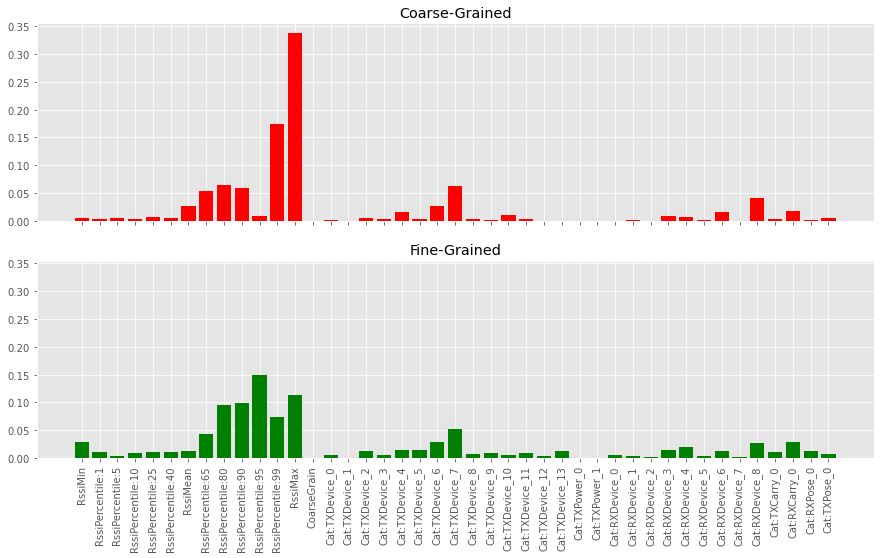

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

m0, m1 = report["model:cg=0"], report["model:cg=1"]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(15, 8))
ax0, ax1 = axes.flatten()
ax0.bar(predictors, m0.feature_importances_, color="red")
ax0.set_title("Coarse-Grained")
ax0.tick_params(axis='x', rotation=90)
ax1.bar(predictors, m1.feature_importances_, color='green')
ax1.set_title("Fine-Grained")
ax1.tick_params(axis='x', rotation=90)